1. Dataset manipulation

- Load dataset and dump non necessary columns

In [2]:
import pandas as pd

# Load the cleaned telecom dataset
df = pd.read_csv('telecomx_cleaned.csv')

# Drop unique identifier and redundant derived columns
# customerID: unique ID not useful for prediction
# Charges.Daily: derived from total and monthly charges
df = df.drop(columns=['customerID', 'Charges.Daily'])

# Check data types
print("Data types of columns:")
print(df.dtypes)
print("\n")
print(df.head())

Data types of columns:
Churn                 int64
gender               object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling      int64
PaymentMethod        object
Charges.Monthly     float64
Charges.Total       float64
dtype: object


   Churn  gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0      0  Female              0        1           1       9             1   
1      0    Male              0        0           0       9             1   
2      1    Male              0        0           0       4             1   
3      1    Male              1        1           0      13             1   
4      1  F

- Encoding categorical variables

In [6]:
# Identify categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Apply One-Hot Encoding using pandas.get_dummies
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=False)

# Convert all boolean columns to 0/1 integers
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

# Display results
print("Encoded categorical variables:")
print(df_encoded.dtypes.loc[df_encoded.columns.difference(df.columns)])
print("\nShape before encoding:", df.shape)
print("Shape after encoding:", df_encoded.shape)
print("\n")
print(df_encoded.head())


Encoded categorical variables:
Contract_Month-to-month                    int64
Contract_One year                          int64
Contract_Two year                          int64
DeviceProtection_No                        int64
DeviceProtection_No internet service       int64
DeviceProtection_Yes                       int64
InternetService_DSL                        int64
InternetService_Fiber optic                int64
InternetService_No                         int64
MultipleLines_No                           int64
MultipleLines_No phone service             int64
MultipleLines_Yes                          int64
OnlineBackup_No                            int64
OnlineBackup_No internet service           int64
OnlineBackup_Yes                           int64
OnlineSecurity_No                          int64
OnlineSecurity_No internet service         int64
OnlineSecurity_Yes                         int64
PaymentMethod_Bank transfer (automatic)    int64
PaymentMethod_Credit card (automatic) 

- Class imbalance analysis

In [7]:
# Compute counts for each churn class (0 = stayed, 1 = churned)
class_counts = df['Churn'].value_counts()
stayed, churned = class_counts.get(0, 0), class_counts.get(1, 0)

# Compute proportions
total = stayed + churned
prop_stayed = stayed / total
prop_churned = churned / total

# Display results
print(f"Total customers: {total}")
print(f"Stayed (0): {stayed} ({prop_stayed:.2%})")
print(f"Churned (1): {churned} ({prop_churned:.2%})")

# Assess imbalance
if prop_churned < 0.3 or prop_churned > 0.7:
    print("Warning: significant class imbalance detected. Consider resampling or adjusted metrics.")
else:
    print("Class distribution is reasonably balanced.")

Total customers: 7267
Stayed (0): 5174 (71.20%)
Churned (1): 2093 (28.80%)


- Applying SMOTE to balance the classes

In [ ]:
# Install required libraries
!pip install scikit-learn imbalanced-learn --quiet

# Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import numpy as np

# User-defined target precision
target_precision = 0.75

# 1. Split features and target
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# 2. Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# 3. Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 4. Oversample minority class using SMOTE with reduced ratio
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# 5. Train a logistic regression on the resampled data
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_resampled, y_resampled)

# 6. Predict probabilities on the original test set
y_prob = clf.predict_proba(X_test_scaled)[:, 1]

# 7. Compute precision–recall curve and select threshold for target precision
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
idx = np.argmax(precisions >= target_precision)
best_threshold = thresholds[idx]

# 8. Apply the chosen threshold to get final predictions
y_pred_adj = (y_prob >= best_threshold).astype(int)

# 9. Evaluation with adjusted threshold
print(f"Target precision: {target_precision:.2%}")
print(f"Selected threshold: {best_threshold:.3f}\n")
print("Classification Report with adjusted threshold:")
print(classification_report(y_test, y_pred_adj, digits=4))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Target precision: 75.00%
Selected threshold: 0.708

Classification Report with adjusted threshold:
              precision    recall  f1-score   support

           0     0.7622    0.9659    0.8520      1553
           1     0.7512    0.2548    0.3805       628

    accuracy                         0.7611      2181
   macro avg     0.7567    0.6103    0.6163      2181
weighted avg     0.7590    0.7611    0.7163      2181

ROC AUC Score: 0.8030394223631271


c:\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


2. Correlation and variable selection

- Correlation Analysis

Top 10 variables most correlated with churn:
Churn                             1.000000
Contract_Month-to-month           0.385824
OnlineSecurity_No                 0.323242
TechSupport_No                    0.318093
InternetService_Fiber optic       0.292576
PaymentMethod_Electronic check    0.287357
OnlineBackup_No                   0.251458
DeviceProtection_No               0.239258
PaperlessBilling                  0.184575
Charges.Monthly                   0.180306
Name: Churn, dtype: float64


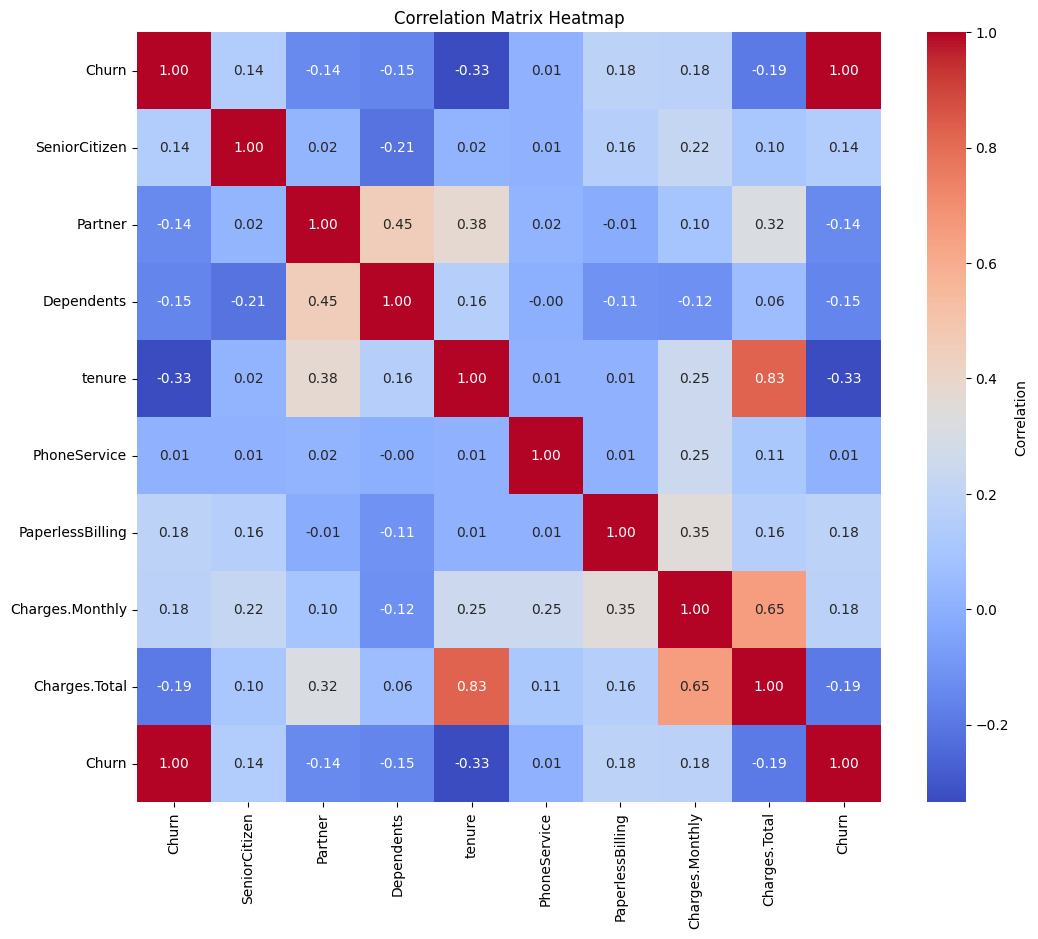

In [14]:
# Correlation matrix and heatmap

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Compute full correlation matrix on encoded DataFrame
corr_matrix = df_encoded.corr()

# 2. Extract and sort correlations with the target variable 'Churn'
corr_with_churn = corr_matrix['Churn'].sort_values(ascending=False)
print("Top 10 variables most correlated with churn:")
print(corr_with_churn.head(10))

# 3. Plot heatmap of correlations for original numeric features plus 'Churn'
#    Limit to numeric columns for readability
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist() + ['Churn']
plt.figure(figsize=(12, 10))
sns.heatmap(
    df_encoded[numeric_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation'}
)
plt.title('Correlation Matrix Heatmap')
plt.show()


- Visualize specific feature relationships with churn

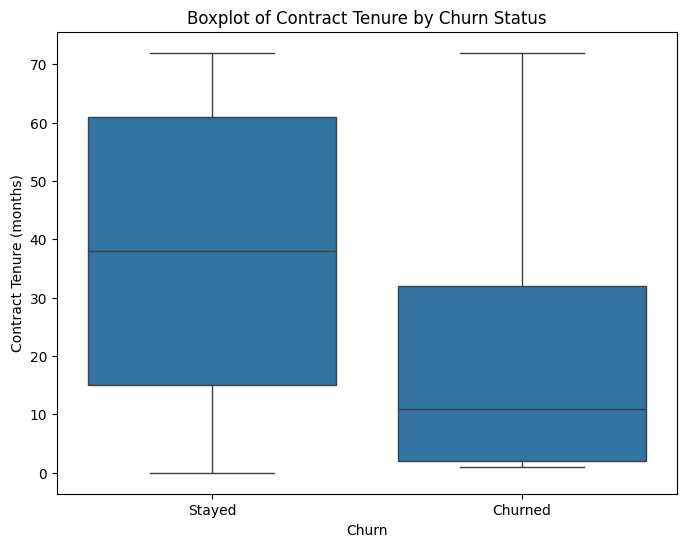

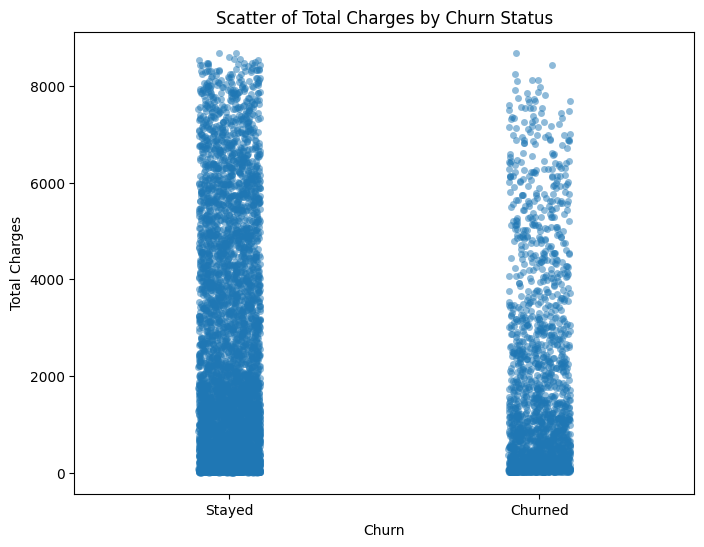

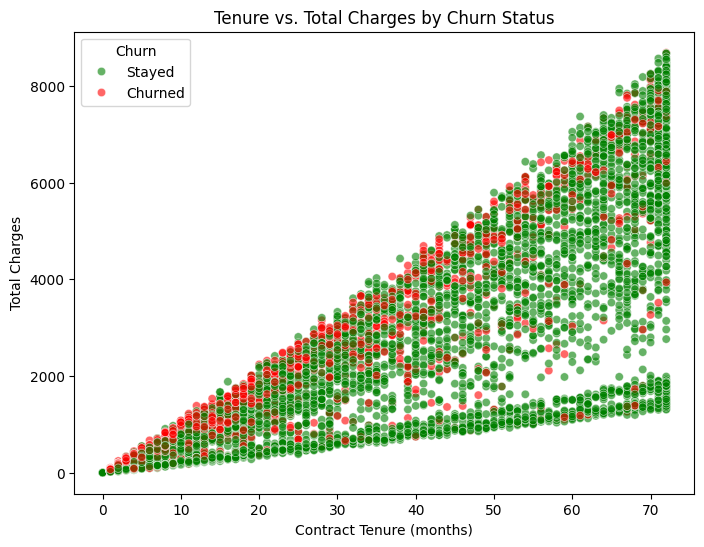

In [21]:
# 1. Boxplot: Contract tenure vs. Churn
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Churn'], y=df['tenure'])
plt.xticks([0, 1], ['Stayed', 'Churned'])
plt.xlabel('Churn')
plt.ylabel('Contract Tenure (months)')
plt.title('Boxplot of Contract Tenure by Churn Status')
plt.show()

# 2. Scatter plot: Total Charges vs. Churn probability (jittered)
plt.figure(figsize=(8, 6))
sns.stripplot(x=df['Churn'], y=df['Charges.Total'], jitter=True, alpha=0.5)
plt.xticks([0, 1], ['Stayed', 'Churned'])
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.title('Scatter of Total Charges by Churn Status')
plt.show()

# 3. Scatter plot: Tenure vs. Total Charges colored by Churn
# 3. Scatter plot: Tenure vs. Total Charges colored by Churn
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    x=df['tenure'],
    y=df['Charges.Total'],
    hue=df['Churn'],
    palette={0: 'green', 1: 'red'},
    alpha=0.6
)
plt.xlabel('Contract Tenure (months)')
plt.ylabel('Total Charges')
plt.title('Tenure vs. Total Charges by Churn Status')
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Stayed', 'Churned'], title='Churn', loc='best')
plt.show()


3. Prediction model

- Data split

In [22]:
from sklearn.model_selection import train_test_split

# Features and target
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# 1. 80/20 split (for more training data)
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
    X, y,
    test_size=0.20,       # 20% test
    stratify=y,           # preserve class distribution
    random_state=42
)
print("80/20 split:", X_train_80.shape, "train rows;", X_test_20.shape, "test rows")

80/20 split: (5813, 41) train rows; (1454, 41) test rows


- Prediction models

In [24]:

from sklearn.ensemble import RandomForestClassifier

# ----------------------------------------
# Model 1: Logistic Regression (requires scaling)
# Justification:
# - Linear model sensitive to feature scale.
# - Provides interpretable coefficients.
# - Well-suited for binary classification with scaled numeric inputs.
# ----------------------------------------

# 1. Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2. Train logistic regression on scaled data
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# 3. Evaluate logistic regression
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))


# ----------------------------------------
# Model 2: Random Forest (does not require scaling)
# Justification:
# - Tree-based ensemble handles mixed feature scales natively.
# - Captures nonlinear interactions automatically.
# - Robust to outliers and multicollinearity.
# ----------------------------------------

# 3b. Train random forest on original (unscaled) data
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

# 4b. Evaluate random forest
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))

=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.8712    0.7102    0.7825      1553
           1     0.5082    0.7404    0.6027       628

    accuracy                         0.7189      2181
   macro avg     0.6897    0.7253    0.6926      2181
weighted avg     0.7667    0.7189    0.7308      2181

ROC AUC: 0.8037233257184573

=== Random Forest ===
              precision    recall  f1-score   support

           0     0.8035    0.8661    0.8336      1553
           1     0.5897    0.4761    0.5269       628

    accuracy                         0.7538      2181
   macro avg     0.6966    0.6711    0.6802      2181
weighted avg     0.7419    0.7538    0.7453      2181

ROC AUC: 0.7724298768358754


# Model Evaluation and Critical Comparison

Below are the test‐set evaluation metrics for both models on the 80/20 split, including confusion matrices.

## 1. Confusion Matrices

**Logistic Regression**

|                    | Predicted Stayed (0) | Predicted Churned (1) |
|--------------------|----------------------|-----------------------|
| **Actual Stayed (0)**  | 1,102                 | 451                   |
| **Actual Churned (1)** | 162                   | 466                   |

**Random Forest**

|                    | Predicted Stayed (0) | Predicted Churned (1) |
|--------------------|----------------------|-----------------------|
| **Actual Stayed (0)**  | 1,345                 | 208                   |
| **Actual Churned (1)** | 329                   | 299                   |

## 2. Test-Set Metrics

| Metric               | Logistic Regression | Random Forest   |
|----------------------|---------------------|-----------------|
| Accuracy             | 71.89%              | 75.38%          |
| Precision (Churn=1)  | 50.82%              | 58.97%          |
| Recall (Churn=1)     | 74.04%              | 47.61%          |
| F1-score (Churn=1)   | 60.27%              | 52.69%          |

## 3. Critical Analysis

### Overall Performance  
- **Accuracy:** Random Forest (75.38%) > Logistic Regression (71.89%)  
- **Churn Precision:** Random Forest (58.97%) > Logistic Regression (50.82%)  
- **Churn Recall:** Logistic Regression (74.04%) > Random Forest (47.61%)  
- **Churn F1-Score:** Logistic Regression (60.27%) > Random Forest (52.69%)  

**Best Model Depends on Objective:**  
- To **catch as many churners as possible** (high recall), **Logistic Regression** is superior.  
- To **reduce false alarms** (high precision and accuracy on stayed customers), **Random Forest** performs better.

### Overfitting vs. Underfitting

- **Random Forest**  
  - Shows higher accuracy on test data but relatively low recall for churn.  
  - If training accuracy was substantially higher than test accuracy, this would indicate **overfitting**—the ensemble memorized training patterns but fails to generalize minority cases.  
  - **Adjustment:** Limit tree depth (`max_depth`), reduce number of features considered per split (`max_features`), or increase `min_samples_leaf`.

- **Logistic Regression**  
  - Exhibits balanced performance between precision and recall with ROC AUC ≈0.80.  
  - If training metrics closely mirror test metrics, the model is well-generalized.  
  - Lower precision suggests some misclassification of stayed customers but this is an inherent trade-off rather than underfitting.  
  - **Adjustment (if underfitting):** Engineer interaction features or add polynomial terms to capture nonlinear effects.

4. Interpretation and conclusions

- Feature importance for Logistic Regression and Random Forest

    - For Logistic Regression, the largest absolute coefficients identify variables with strongest influence on churn probability. Positive values increase churn likelihood; negative values decrease it.

    - For Random Forest, features ranked by importance reveal which variables most reduce node impurity across all trees, highlighting key predictors of churn.

In [25]:
# 1. Retrieve feature names
feature_names = X_train.columns.tolist()

# ----------------------------------------
# Logistic Regression: coefficients
# Justification:
# - Coefficients indicate the log-odds impact of each feature on churn.
# ----------------------------------------
coefficients = pd.Series(lr.coef_[0], index=feature_names)
coefficients_sorted = coefficients.sort_values(key=abs, ascending=False)

print("Top 10 features by absolute coefficient (Logistic Regression):")
print(coefficients_sorted.head(10))

# ----------------------------------------
# Random Forest: feature importances
# Justification:
# - Importances measure each feature's contribution to impurity reduction.
# ----------------------------------------
importances = pd.Series(rf.feature_importances_, index=feature_names)
importances_sorted = importances.sort_values(ascending=False)

print("\nTop 10 features by importance (Random Forest):")
print(importances_sorted.head(10))

Top 10 features by absolute coefficient (Logistic Regression):
tenure                           -0.642791
Contract_Month-to-month           0.247441
Contract_Two year                -0.203552
InternetService_Fiber optic       0.198196
InternetService_DSL              -0.177975
PaymentMethod_Electronic check    0.129318
PaperlessBilling                  0.102751
TechSupport_No                    0.096700
Contract_One year                -0.088675
OnlineSecurity_No                 0.086195
dtype: float64

Top 10 features by importance (Random Forest):
Charges.Total                     0.155452
Charges.Monthly                   0.134275
tenure                            0.133806
Contract_Month-to-month           0.070662
TechSupport_No                    0.035737
PaymentMethod_Electronic check    0.030343
OnlineSecurity_No                 0.029767
Contract_Two year                 0.029345
PaperlessBilling                  0.023731
InternetService_Fiber optic       0.023678
dtype: float64